In [1]:
import requests
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
# from random import shuffle

In [2]:
# australian_data_url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/australian_scale'
# data = requests.get(australian_data_url)
australian_svmlight_file_name = 'australian_scale.svm'
# with open(australian_svmlight_file_name, 'w') as f:
#     f.write(data.text)

In [3]:
def loss_fn(w, x, y, reg):
    num_train = x.shape[0]
    num_classes = w.shape[1]
    scores = x.dot(w)
    correct_class_scores = scores[range(num_train), list(y)].reshape(-1, 1)
    margins = np.maximum(0, scores - correct_class_scores + 1)
    margins[range(num_train), list(y)] = 0
    loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(w * w)
    coeff_mat = np.zeros((num_train, num_classes))
    coeff_mat[margins > 0] = 1
    coeff_mat[range(num_train), list(y)] = 0
    coeff_mat[range(num_train), list(y)] = - np.sum(coeff_mat, axis=1)
    
    dw = x.T.dot(coeff_mat)
    dw = dw / num_train + reg * w
    return loss, dw

In [12]:
class LinearClassifier:
    def __init__(self):
        self.w = None
        self.le = LabelEncoder()
        
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=2000, batch_size=200, verbose=False):
        num_train, dim = X.shape
        y = self.le.fit_transform(y)
        
        num_classes = int(np.max(y)) + 1
        if self.w is None:
            print(dim, num_classes)
            self.w = 0.001 * np.random.randn(dim, num_classes)
            
        loss_history = []
        for i in range(num_iters):
            batch_idx = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
            
            loss, grad = self.loss(X_batch, y_batch, reg)
            
            loss_history.append(loss)
            
            self.w += -1 * learning_rate * grad
            
            if verbose and i % 100 == 0:
                print('iteration %d / %d: loss %f' % (i, num_iters, loss))
                
        return loss_history
        
    def predict(self, X):
        y_pred = np.zeros(X.shape[1])
        scores = X.dot(self.w)
        y_pred = np.argmax(scores, axis=1)
        y_pred = self.le.inverse_transform(y_pred)
        return y_pred

In [13]:
class LinearSVM(LinearClassifier):
    def loss(self, X_batch, y_batch, reg):
        return loss_fn(self.w, X_batch, y_batch, reg)

In [14]:
X, y = load_svmlight_file(australian_svmlight_file_name)

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

In [16]:
clf = LinearSVM()
loss_history = clf.train(X_train, y_train, verbose=True)

14 2
iteration 0 / 2000: loss 0.999609
iteration 100 / 2000: loss 0.803446
iteration 200 / 2000: loss 0.636249
iteration 300 / 2000: loss 0.579814
iteration 400 / 2000: loss 0.445851
iteration 500 / 2000: loss 0.388246
iteration 600 / 2000: loss 0.348267
iteration 700 / 2000: loss 0.320205
iteration 800 / 2000: loss 0.380662
iteration 900 / 2000: loss 0.371449
iteration 1000 / 2000: loss 0.334343
iteration 1100 / 2000: loss 0.237586
iteration 1200 / 2000: loss 0.350657
iteration 1300 / 2000: loss 0.317077
iteration 1400 / 2000: loss 0.358275
iteration 1500 / 2000: loss 0.277891
iteration 1600 / 2000: loss 0.276728
iteration 1700 / 2000: loss 0.322186
iteration 1800 / 2000: loss 0.224671
iteration 1900 / 2000: loss 0.393273


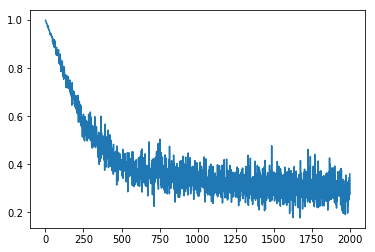

In [17]:
plt.plot(loss_history)
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, clf.predict(X_train))

0.85688405797101452

In [19]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
lsvc.score(X_train, y_train)

0.86413043478260865

In [20]:
loss_history_validation = LinearSVM().train(X_validation, y_validation)

14 2


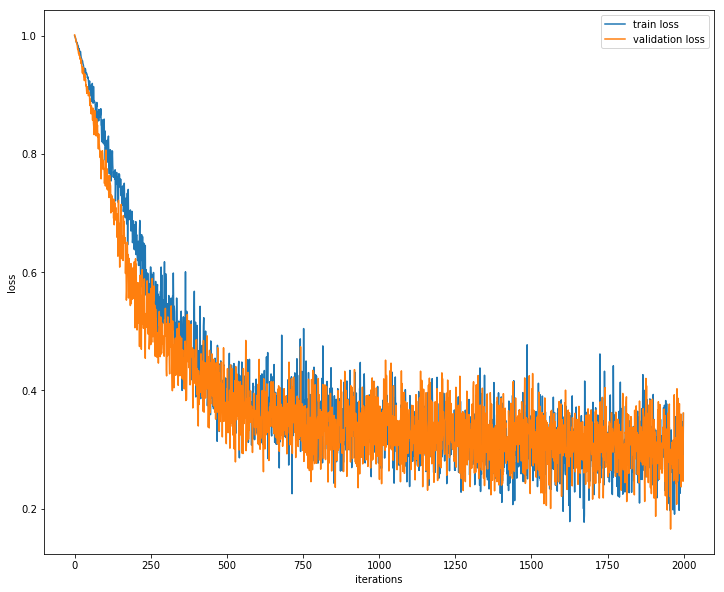

In [21]:
plt.figure('loss', figsize=(12, 10))
plt.plot(loss_history, label='train loss')
plt.plot(loss_history_validation, label='validation loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()